In [15]:
import torch
import sys
import os

# simple_cnn_inference.py를 import할 수 있도록 경로 추가
# sys.path.insert(0, os.path.dirname(__file__))

from simple_cnn_inference import (
    load_policy,
    infer,
    create_proprio_observation,
    create_example_observation,
    create_realistic_observation,
    ActorDepthCNN,
    get_activation
)

print("✓ simple_cnn_inference.py import 완료!")


✓ simple_cnn_inference.py import 완료!


In [16]:
# 예제 1: 랜덤 observation으로 테스트
print("=" * 50)
print("예제 1: 랜덤 observation 생성 및 추론")
print("=" * 50)

obs_random = create_example_observation()
print(f"Proprio shape: {obs_random['proprio'].shape}")
print(f"Depth shape: {obs_random['depth'].shape}")
print(f"Proprio preview: {obs_random['proprio'][:5]}")


예제 1: 랜덤 observation 생성 및 추론
Proprio shape: torch.Size([51])
Depth shape: torch.Size([24, 32])
Proprio preview: tensor([0.1054, 0.5699, 0.3515, 0.1853, 1.2444])


In [17]:
obs_random

{'proprio': tensor([ 0.1054,  0.5699,  0.3515,  0.1853,  1.2444,  0.1336, -0.7459,  1.5702,
          1.0583,  0.1525,  0.0826,  0.5568,  0.4195, -0.3913, -0.8818, -0.4011,
         -1.0358, -1.4675,  3.2118,  1.1467, -0.7839, -0.1146, -0.3465, -1.0520,
          0.2338,  0.9723, -0.4603,  1.9210, -0.7917, -1.1625, -0.1431,  1.3423,
          1.9252, -0.6471,  1.0732,  0.9741, -0.8072, -0.8444, -0.3499, -0.1863,
          0.3849,  0.1590,  2.0997, -0.0312, -2.5102, -1.4264,  0.0653,  0.2138,
         -1.0062,  0.9449, -0.4754]),
 'depth': tensor([[ 3.6049e-01,  7.7654e-01,  2.4428e-01,  4.6834e-01,  1.2189e+00,
           1.7443e+00, -1.0539e+00,  1.6481e-01,  1.8033e+00, -6.0123e-01,
          -6.1654e-01,  4.2972e-01,  4.7338e-01,  1.7564e+00, -2.3715e-01,
           1.9591e+00,  1.7966e+00,  9.8794e-01,  3.8107e-02, -3.7254e-01,
          -1.2526e+00,  1.5738e+00, -1.4835e-01,  3.3329e-01, -6.9247e-01,
           6.2788e-01, -4.7322e-01,  3.7156e-01, -1.6710e-01, -2.8425e-01,
      

In [16]:
# 예제 2: Custom proprio observation 생성
print("\n" + "=" * 50)
print("예제 2: Custom proprio observation 생성")
print("=" * 50)

custom_proprio = create_proprio_observation(
    base_lin_vel=torch.tensor([1.0, 0.0, 0.0]),      # 전진 속도
    base_ang_vel=torch.tensor([0.0, 0.0, 0.1]),     # 회전 속도
    velocity_commands=torch.tensor([1.0, 0.0, 0.0]), # 전진 명령
    joint_pos=torch.ones(12) * 0.5                   # 모든 관절 위치
)

print(f"Custom proprio shape: {custom_proprio.shape}")
print(f"Custom proprio preview: {custom_proprio[:5]}")



예제 2: Custom proprio observation 생성
Custom proprio shape: torch.Size([51])
Custom proprio preview: tensor([1., 0., 0., 0., 0.])


In [23]:
# 예제 3: 모델 로드 및 추론
print("\n" + "=" * 50)
print("예제 3: 모델 추론")
print("=" * 50)

# 모델 파일 경로를 여기에 지정하세요
# model_path = "path/to/your/model.pt"
# actor = load_policy(model_path)

# 예제: actor 네트워크 생성 (가중치 없이)
actor = ActorDepthCNN(
    num_obs_proprio=51,
    obs_depth_shape=(24, 32),
    num_actions=12,
    activation=get_activation("elu"),
    hidden_dims=[512, 256, 128]
)
actor.eval()

# Realistic observation 생성
obs_realistic = create_realistic_observation()

# 추론 실행
actions = infer(obs_realistic, actor)
print(f"Action shape: {actions.shape}")
print(f"Action values: {actions}")



예제 3: 모델 추론
Action shape: torch.Size([12])
Action values: tensor([ 0.0523,  0.0308,  0.0243,  0.0467,  0.0011, -0.0254,  0.0836, -0.0520,
         0.0881,  0.1184,  0.0622,  0.0847])


In [24]:
## 추론 시간 체크 
# >> 10000회 추론 소요시간: 11.2238초, 1회 평균: 1.12 ms
import time

num_iters = 10000  # 실행 반복 횟수
start_time = time.time()
for _ in range(num_iters):
    actions = infer(obs_realistic, actor)
end_time = time.time()
elapsed = end_time - start_time

print(f"{num_iters}회 추론 소요시간: {elapsed:.4f}초, 1회 평균: {elapsed/num_iters*1000:.2f} ms")

10000회 추론 소요시간: 11.2711초, 1회 평균: 1.13 ms


## 사용법 가이드

### 1. 모델 로드
```python
actor = load_policy('path/to/model.pt')
```

### 2. Observation 생성
```python
# 방법 1: 전체 observation 딕셔너리 생성
obs = create_example_observation()  # 랜덤 데이터
# 또는
obs = create_realistic_observation()  # 현실적인 데이터

# 방법 2: 개별 관찰 데이터 생성
proprio = create_proprio_observation(
    base_lin_vel=torch.tensor([1.0, 0.0, 0.0]),
    joint_pos=torch.ones(12) * 0.5,
    # ... 기타 파라미터
)
depth = torch.rand(24, 32)  # 또는 실제 depth 이미지
obs = {'proprio': proprio, 'depth': depth}
```

### 3. 추론 실행
```python
actions = infer(obs, actor)
print(actions)  # Shape: (12,)
```


In [59]:
obs = torch.tensor([ 0.8575, -0.0948,  0.0563,  0.2249,  0.3990,  0.0685,  0.0506, -0.0384,
        -0.9980,  0.0385,  0.0506,  2.6442,  0.7924,  0.0000,  0.0605, -0.3654,
         0.3511, -0.5220,  0.4951,  0.1077, -0.4340, -1.0017, -0.4039, -0.0512,
         0.2090,  0.4591,  0.1756,  1.8514,  0.2528,  1.3268, -0.0775, -3.4569,
         2.2063,  6.1796,  1.6681, -8.2990, -0.6992,  1.4411,  0.6983, -1.3404,
         1.4558, -2.0554,  1.3029, -0.2962, -1.3998, -3.3257, -0.9440, -0.8501,
         1.6138,  2.0035,  2.1563,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.5715,  1.6366,  1.6226,  1.5142,  1.5204,  1.4945,  1.4452,  1.4295,
         1.4105,  1.4286,  1.3861,  1.6251,  1.6351,  1.6451,  1.6449,  1.6227,
         1.6009,  1.4073,  1.3884,  1.5385,  1.4829,  1.4638,  1.4451,  1.4268,
         1.2447,  1.0611,  1.0473,  1.0337,  1.0204,  1.0442,  1.0946,  1.3249,
         1.3094,  1.2941,  1.2566,  1.2014,  1.1499,  1.1313,  1.1192,  1.1072,
         1.1181,  1.1186,  1.0252,  1.2361,  1.2222,  1.0702,  1.0580,  1.0461,
         1.0343,  1.0247,  1.0590,  0.9859,  0.9751,  0.9644,  0.9539,  0.9435,
         0.9334,  0.8717,  0.9148,  0.9558,  0.9998,  0.9905,  0.9804,  0.9705,
         0.9885,  0.9787,  0.9691,  0.9595,  0.9502,  0.9409,  0.9284,  0.8941,
         0.8604,  0.8071,  0.7734,  0.7634,  0.8776,  0.9047,  0.9181,  0.9093,
         0.9007,  0.8922,  0.8838,  0.7528,  0.7014,  0.6945,  0.6877,  0.6810,
         0.6744,  0.6678,  0.6614,  0.6550,  0.7788,  0.7718,  0.7649,  0.7580,
         0.7512,  0.6201,  0.6143,  0.6085,  0.6028,  0.5972,  0.7346,  0.7283,
         0.7221,  0.7159,  0.7098,  0.7445,  0.7381,  0.7317,  0.5704,  0.5651,
         0.5599,  0.5548,  0.5497,  0.5536,  0.5486,  0.5436,  0.5387,  0.5339,
         0.5291,  0.5244,  0.5197,  0.5151,  0.5105,  0.5060,  0.5028,  0.4984,
         0.4940,  0.4897,  0.4854,  0.4811,  0.4769,  0.4728,  0.4687,  0.4646,
         0.4606,  0.4566,  0.5733,  0.4636,  0.4595,  0.4555,  0.4515,  0.4476,
         0.4437,  0.4399,  0.4361,  0.4323,  0.4363,  0.4325,  0.4288,  0.4252,
         0.4216,  0.4180,  0.4190,  0.4435,  0.4696,  0.4971,  0.4652,  0.4033,
         0.3949,  0.3916,  0.3883,  0.3851,  0.3818,  0.3786,  0.3755,  0.3723,
         0.3692,  0.3662,  0.3631,  0.3705,  0.3674,  0.3643,  0.3612,  0.3582,
         0.3552,  0.3522,  0.3492,  0.3463,  0.3502,  0.3473,  0.3444,  0.3556,
         0.3758,  0.3974,  0.4168,  0.4137,  0.4106,  0.4075,  0.4045,  0.4015,
         0.3539,  0.3152,  0.3126,  0.3101,  0.3075,  0.3050,  0.3024,  0.2999,
         0.2975,  0.2950,  0.2926,  0.2977,  0.2952,  0.2928,  0.2903,  0.2879,
         0.2855,  0.2831,  0.2633,  0.2610,  0.3024,  0.3195,  0.3375,  0.3513,
         0.3487,  0.3461,  0.3436,  0.3411,  0.3386,  0.3361,  0.3336,  0.3312,
         0.3287,  0.3110,  0.2709,  0.2498,  0.2478,  0.2457,  0.2436,  0.2416,
         0.2396,  0.2376,  0.2356,  0.2392,  0.2371,  0.2351,  0.2171,  0.2152,
         0.2133,  0.2114,  0.2095,  0.2077,  0.2967,  0.2945,  0.2924,  0.2902,
         0.2881,  0.2860,  0.2839,  0.2818,  0.2798,  0.2777,  0.2757,  0.2737,
         0.2717,  0.2697,  0.2677,  0.2379,  0.2066,  0.1970,  0.1953,  0.1936,
         0.1919,  0.1903,  0.1886,  0.1763,  0.1747,  0.1731,  0.1714,  0.1699,
         0.1683,  0.1667,  0.1651,  0.1636,  0.2451,  0.2432,  0.2414,  0.2397,
         0.2379,  0.2361,  0.2344,  0.2326,  0.2309,  0.2292,  0.2275,  0.2258,
         0.2241,  0.2224,  0.2208,  0.2191,  0.2085,  0.1804,  0.1553,  0.1534,
         0.1520,  0.1506,  0.1641])

In [40]:
obs

{'proprio': tensor([ 0.8575, -0.0948,  0.0563,  0.2249,  0.3990,  0.0685,  0.0506, -0.0384,
         -0.9980,  0.0385,  0.0506,  2.6442,  0.7924,  0.0000,  0.0605, -0.3654,
          0.3511, -0.5220,  0.4951,  0.1077, -0.4340, -1.0017, -0.4039, -0.0512,
          0.2090,  0.4591,  0.1756,  1.8514,  0.2528,  1.3268, -0.0775, -3.4569,
          2.2063,  6.1796,  1.6681, -8.2990, -0.6992,  1.4411,  0.6983, -1.3404,
          1.4558, -2.0554,  1.3029, -0.2962, -1.3998, -3.3257, -0.9440, -0.8501,
          1.6138,  2.0035,  2.1563]),
 'depth': tensor([[1.7000, 1.7000, 1.7000, 1.7000, 1.7000, 1.7000, 1.7000, 1.7000, 1.7000,
          1.7000, 1.7000, 1.7000, 1.7000, 1.7000, 1.7000, 1.7000, 1.7000, 1.7000,
          1.7000, 1.7000, 1.7000, 1.7000, 1.7000, 1.7000, 1.7000, 1.7000, 1.7000,
          1.7000, 1.7000, 1.7000, 1.7000, 1.7000],
         [1.7000, 1.7000, 1.7000, 1.7000, 1.7000, 1.7000, 1.7000, 1.7000, 1.7000,
          1.7000, 1.7000, 1.7000, 1.7000, 1.7000, 1.7000, 1.7000, 1.7000, 1.7

In [60]:
def make_obs_from_flat_tensor(flat):
    """
    51개는 proprio, 나머지는 24x32로 reshape 해서 depth로 dict로 반환.
    Args:
        flat (array-like or torch.Tensor): (51 + 768,) shape 또는 그 이상

    Returns:
        dict: {'proprio': torch.Tensor(51,), 'depth': torch.Tensor(24,32)}
    """
    flat = torch.as_tensor(flat, dtype=torch.float32)
    proprio = flat[:51]
    depth_raw = flat[51:]
    depth = depth_raw.reshape(24, 32)
    return {"proprio": proprio, "depth": depth}

# 예시:
# flat_data = torch.cat([proprio_tensor, depth_tensor.flatten()], dim=0)
# obs = make_obs_from_flat_tensor(flat_data)
obs = make_obs_from_flat_tensor(obs)

In [ ]:
# Load Model
actor = load_policy("./model_1500.pt")
obsmod = obs
obsmod['proprio'][0:3] = torch.tensor([0]*3)
act = infer(obsmod,actor)
print(act)
print(torch.tensor(obs2[0:51][-12:]))
act - torch.tensor(obs2[0:51][-12:]) # Simulation  에서 돌린 값

tensor([-1.2891,  1.5916, -2.0150,  1.6452, -0.3752,  0.3254, -1.5643, -1.0960,
        -1.1761,  1.2251,  3.1633,  2.5241])
tensor([-1.5323,  1.4793, -2.1506,  1.6954, -0.6748, -1.1294, -3.2514, -1.4343,
        -0.9111,  2.1069,  2.2329,  1.4590])


tensor([ 0.2432,  0.1123,  0.1356, -0.0502,  0.2996,  1.4548,  1.6871,  0.3383,
        -0.2650, -0.8818,  0.9304,  1.0651])

In [66]:
obs2[0:51][-12:] # Simulation  에서 돌린 값

[-1.5323,
 1.4793,
 -2.1506,
 1.6954,
 -0.6748,
 -1.1294,
 -3.2514,
 -1.4343,
 -0.9111,
 2.1069,
 2.2329,
 1.459]

In [76]:
np.linalg.norm(np.array([0.8575, -0.0948,  0.0563]))

0.8645594138056678

In [5]:
obs = [ 0.8249, -0.0841,  0.0609,  0.3209,  0.2600,  0.1070,  0.0558, -0.0461,
        -0.9974,  0.0462,  0.0558,  2.6461,  0.7924,  0.0000,  0.0595, -0.3614,
         0.3551, -0.5186,  0.4916,  0.0299, -0.4008, -0.9144, -0.3664, -0.1314,
         0.2164,  0.4206,  0.1846, -1.5743,  0.2659,  0.0053, -0.1578, -1.1460,
         1.1299,  3.0969,  1.6914, -1.2098,  1.2192, -2.4923,  0.7213, -1.5323,
         1.4793, -2.1506,  1.6954, -0.6748, -1.1294, -3.2514, -1.4343, -0.9111,
         2.1069,  2.2329,  1.4590,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,  1.7000,
         1.7000,  1.7000,  1.7000,  1.7000,  1.4263,  1.7000,  1.7000,  1.6781,
         1.5467,  1.5987,  1.5927,  1.4468,  1.4710,  1.4407,  1.3787,  1.3066,
         1.3767,  1.3718,  1.3515,  1.6321,  1.6398,  1.6475,  1.6545,  1.6276,
         1.6014,  1.5759,  1.3814,  1.5270,  1.4680,  1.4455,  1.4236,  1.4022,
         1.2308,  1.0367,  1.0207,  1.0051,  0.9898,  1.0260,  1.0756,  1.2795,
         1.2619,  1.2447,  1.2278,  1.1736,  1.1226,  1.0636,  1.0529,  1.0789,
         1.0707,  1.0503,  0.9984,  1.2508,  1.2338,  1.0780,  1.0633,  1.0488,
         1.0346,  1.0208,  1.0471,  0.9797,  0.9668,  0.9542,  0.9418,  0.9297,
         0.9178,  0.8552,  0.8989,  0.9392,  0.9768,  0.9650,  0.9534,  0.9421,
         0.9309,  0.9468,  0.9358,  0.9250,  0.9144,  0.9039,  0.8937,  0.8726,
         0.8400,  0.7919,  0.7570,  0.7741,  0.8677,  0.8945,  0.9220,  0.9115,
         0.9011,  0.8909,  0.8809,  0.7487,  0.6961,  0.6880,  0.6799,  0.6720,
         0.6642,  0.6566,  0.6490,  0.6416,  0.7624,  0.7542,  0.7462,  0.7383,
         0.7304,  0.6008,  0.5942,  0.5876,  0.5811,  0.5747,  0.7076,  0.7004,
         0.6933,  0.6863,  0.6794,  0.7514,  0.7436,  0.7359,  0.7283,  0.5664,
         0.5601,  0.5540,  0.5479,  0.5508,  0.5449,  0.5390,  0.5332,  0.5275,
         0.5218,  0.5162,  0.5107,  0.5053,  0.5000,  0.4947,  0.4907,  0.4856,
         0.4805,  0.4755,  0.4705,  0.4656,  0.4608,  0.4560,  0.4513,  0.4467,
         0.4421,  0.4376,  0.5506,  0.4679,  0.4630,  0.4581,  0.4533,  0.4486,
         0.4439,  0.4393,  0.4347,  0.4380,  0.4335,  0.4291,  0.4247,  0.4203,
         0.4160,  0.4118,  0.4076,  0.4272,  0.4527,  0.4800,  0.4565,  0.3947,
         0.3846,  0.3808,  0.3769,  0.3732,  0.3694,  0.3657,  0.3621,  0.3585,
         0.3549,  0.3513,  0.3478,  0.3739,  0.3701,  0.3664,  0.3627,  0.3590,
         0.3554,  0.3518,  0.3482,  0.3447,  0.3481,  0.3446,  0.3412,  0.3415,
         0.3612,  0.3823,  0.4047,  0.4072,  0.4035,  0.3999,  0.3963,  0.3928,
         0.3461,  0.3067,  0.3036,  0.3006,  0.2976,  0.2947,  0.2918,  0.2889,
         0.2860,  0.2832,  0.2804,  0.3004,  0.2974,  0.2944,  0.2915,  0.2885,
         0.2857,  0.2828,  0.2800,  0.2598,  0.2896,  0.3063,  0.3239,  0.3426,
         0.3448,  0.3418,  0.3388,  0.3358,  0.3328,  0.3299,  0.3270,  0.3241,
         0.3213,  0.3037,  0.2638,  0.2422,  0.2398,  0.2373,  0.2350,  0.2326,
         0.2303,  0.2279,  0.2256,  0.2414,  0.2389,  0.2365,  0.2341,  0.2157,
         0.2134,  0.2112,  0.2089,  0.2067,  0.2905,  0.2926,  0.2900,  0.2875,
         0.2849,  0.2824,  0.2800,  0.2775,  0.2751,  0.2727,  0.2703,  0.2679,
         0.2655,  0.2632,  0.2609,  0.2313,  0.2001,  0.1901,  0.1881,  0.1861,
         0.1842,  0.1823,  0.1803,  0.1929,  0.1761,  0.1742,  0.1722,  0.1703,
         0.1684,  0.1665,  0.1646,  0.1628,  0.2438,  0.2416,  0.2395,  0.2374,
         0.2352,  0.2332,  0.2311,  0.2290,  0.2270,  0.2249,  0.2229,  0.2209,
         0.2189,  0.2170,  0.2150,  0.2131,  0.2023,  0.1744,  0.1493,  0.1471,
         0.1455,  0.1438,  0.1422]

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def split_proprio(proprio):
    """
    proprio 벡터(51,)를 세부 관절 관측값 dict로 분할합니다.

    Args:
        proprio (list or torch.Tensor): (51,) proprio observation

    Returns:
        dict: {
            'base_lin_vel': (3,)
            'base_ang_vel': (3,)
            'projected_gravity': (3,)
            'base_rpy': (3,)
            'velocity_commands': (3,)
            'joint_pos': (12,)
            'joint_vel': (12,)
            'actions': (12,)
        }
    """
    if hasattr(proprio, 'detach'):
        p = proprio.cpu().detach().tolist()
    else:
        p = list(proprio)

    idx = 0
    d = {}
    d['base_lin_vel'] = p[idx:idx+3]; idx += 3
    d['base_ang_vel'] = p[idx:idx+3]; idx += 3
    d['projected_gravity'] = p[idx:idx+3]; idx += 3
    d['base_rpy'] = p[idx:idx+3]; idx += 3
    d['velocity_commands'] = p[idx:idx+3]; idx += 3
    d['joint_pos'] = p[idx:idx+12]; idx += 12
    d['joint_vel'] = p[idx:idx+12]; idx += 12
    d['actions'] = p[idx:idx+12]; idx += 12
    return d

def show_depth_image(depth):
    # depth는 (24*32,)로 평탄화 되어 있을 수 있으니 reshape
    depth_img = np.array(depth).reshape(24, 32)
    plt.imshow(depth_img, cmap='gray')
    plt.colorbar()
    plt.title('Depth Image')
    plt.show()

show_depth_image(depth)




NameError: name 'depth' is not defined

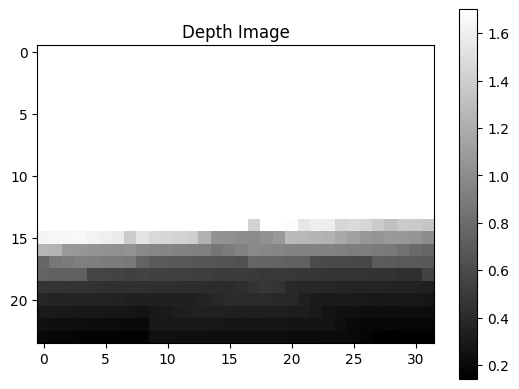

In [11]:
show_depth_image(depth)

In [7]:
priprio = obs[0:50]

depth = obs[51:]

In [13]:
create_example_observation()

NameError: name 'create_example_observation' is not defined